In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Деревья классификации
--------------------------------------

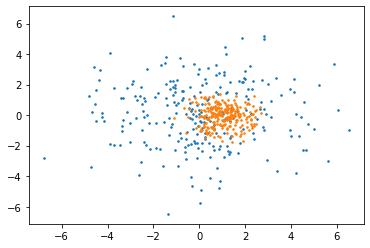

In [4]:
np.random.seed(43)

n = 250

mu1 = np.array([0.0,0])
mu2 = np.array([1.0,0])
sigma1 = 5.0 * np.diag(np.array([1.0, 1.0]))
sigma2 = 0.5 * np.diag(np.array([1.0, 1.0]))

x1 = np.random.multivariate_normal(mu1, sigma1, n)
x2 = np.random.multivariate_normal(mu2, sigma2, n)
x = np.vstack([x1, x2])
y = np.concatenate([np.full(x1.shape[0], 0), np.full(x2.shape[0], 1)])

plt.figure()
plt.scatter(*x1.T,s=2.5)
plt.scatter(*x2.T,s=2.5)

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [0]:
def flat_dict(x):
    if len(x) == 0:
        return dict()
    return {k: np.asarray([e[k] for e in x]) for k in x[0].keys()}

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

max_depths = np.arange(1, 2 * np.log2(n))

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for max_depth in max_depths:
    c = DecisionTreeClassifier(max_depth=max_depth)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

In [0]:
scores = flat_dict(scores)

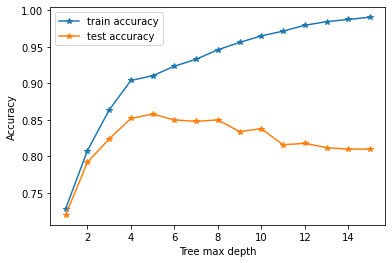

In [19]:
plt.plot(max_depths, scores['train_accuracy'].mean(axis=1), '-*', label="train accuracy")
plt.plot(max_depths, scores['test_accuracy'].mean(axis=1), '-*', label="test accuracy")
plt.xlabel("Tree max depth")
plt.ylabel("Accuracy")
_ = plt.legend()

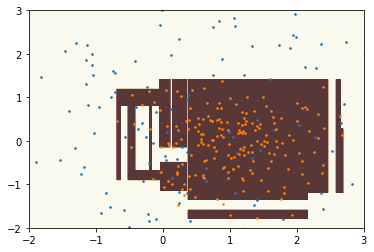

In [20]:
x_grid = np.linspace(np.min(x), np.max(x), 2000)
xx, yy = np.meshgrid(x_grid, x_grid)
xx_test = np.stack((xx,yy), axis=-1).reshape(-1, 2)

c = DecisionTreeClassifier(random_state=0, max_depth=10)

c.fit(x_train, y_train)
pred = c.predict(xx_test).reshape(xx.shape)

x1_train = x_train[y_train == 0]
x2_train = x_train[y_train == 1]

plt.figure()
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.contourf(xx, yy, pred, cmap="pink_r")
plt.scatter(*x1_train.T,s=2.5)
plt.scatter(*x2_train.T,s=2.5)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

min_samples_leafs = np.arange(1, 20)

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for min_samples_leaf in min_samples_leafs:
    c = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

In [0]:
scores = flat_dict(scores)

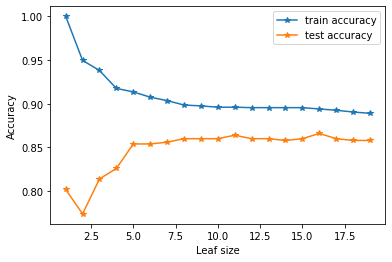

In [23]:
plt.plot(min_samples_leafs, scores['train_accuracy'].mean(axis=1), '-*', label="train accuracy")
plt.plot(min_samples_leafs, scores['test_accuracy'].mean(axis=1), '-*', label="test accuracy")
plt.xlabel("Leaf size")
plt.ylabel("Accuracy")
_ = plt.legend()

In [0]:
c = DecisionTreeClassifier(random_state=0)

path = c.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

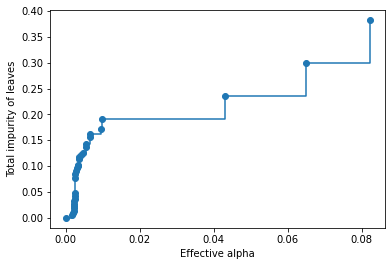

In [25]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
_ = ax.set_ylabel("Total impurity of leaves")

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for ccp_alpha in ccp_alphas:
    c = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

In [0]:

scores = flat_dict(scores)

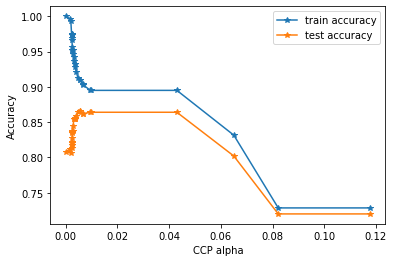

In [28]:
plt.plot(ccp_alphas, scores['train_accuracy'].mean(axis=1), '-*', label="train accuracy")
plt.plot(ccp_alphas, scores['test_accuracy'].mean(axis=1), '-*', label="test accuracy")
plt.xlabel("CCP alpha")
plt.ylabel("Accuracy")
_ = plt.legend()

Деревья классификации своими руками
-----------------------------------------------------

In [0]:
from collections import namedtuple
from scipy import optimize

Leaf = namedtuple('Leaf', ('value', 'x', 'y'))
Node = namedtuple('Node', ('feature', 'value', 'impurity', 'left', 'right',))

class BaseDecisionTree:
    def __init__(self, x, y, max_depth=np.inf):
        self.x = np.atleast_2d(x)
        self.y = np.atleast_1d(y)
        self.max_depth = max_depth
        
        self.features = x.shape[1]
        
        self.root = self.build_tree(self.x, self.y)
    
    # Will fail in case of depth ~ 1000 because of limit of recursion calls
    def build_tree(self, x, y, depth=1):
        if depth > self.max_depth or self.criteria(y) < 1e-6:
            return Leaf(self.leaf_value(y), x, y)
        
        feature, value, impurity = self.find_best_split(x, y)
        
        left_xy, right_xy = self.partition(x, y, feature, value)
        left = self.build_tree(*left_xy, depth=depth + 1)
        right = self.build_tree(*right_xy, depth=depth + 1)
        
        return Node(feature, value, impurity, left, right)
    
    def leaf_value(self, y):
        raise NotImplementedError
    
    def partition(self, x, y, feature, value):
        i = x[:, feature] >= value
        j = np.logical_not(i)
        return (x[j], y[j]), (x[i], y[i])
    
    def _impurity_partition(self, value, feature, x, y):
        (_, left), (_, right) = self.partition(x, y, feature, value)
        return self.impurity(left, right)
    
    def find_best_split(self, x, y):
        best_feature, best_value, best_impurity = 0, x[0,0], np.inf
        for feature in range(self.features):
            if x.shape[0] > 2:
                x_interval = np.sort(x[:,feature])
                res = optimize.minimize_scalar(
                    self._impurity_partition, 
                    args=(feature, x, y),
                    bounds=(x_interval[1], x_interval[-1]),
                    method='Bounded',
                )
                assert res.success
                value = res.x
                impurity = res.fun
            else:
                value = np.max(x[:,feature])
                impurity = self._impurity_partition(value, feature, x, y)
            if impurity < best_impurity:
                best_feature, best_value, best_impurity = feature, value, impurity
        return best_feature, best_value, best_impurity
    
    # Can be optimized for given .criteria()
    def impurity(self, left, right):
        h_l = self.criteria(left)
        h_r = self.criteria(right)
        return (left.size * h_l + right.size * h_r) / (left.size + right.size)
    
    def criteria(self, y):
        raise NotImplementedError
        
    def predict(self, x):
        x = np.atleast_2d(x)
        y = np.empty(x.shape[0], dtype=self.y.dtype)
        for i, row in enumerate(x):
            node = self.root
            while not isinstance(node, Leaf):
                if row[node.feature] >= node.value:
                    node = node.right
                else:
                    node = node.left
            y[i] = node.value
        return y

In [0]:
class MyDecisionTreeClassifier(BaseDecisionTree):
    def __init__(self, x, y, *args, random_state=None, **kwargs):
        y = np.asarray(y, dtype=int)
        self.random_state = np.random.RandomState(random_state)
        self.classes = np.unique(y)
        super().__init__(x, y, *args, **kwargs)
        
    def leaf_value(self, y):
        class_counts = np.sum(y == self.classes.reshape(-1,1), axis=1)
        m = np.max(class_counts)
        most_common = self.classes[class_counts == m]
        if most_common.size == 1:
            return most_common[0]
        return self.random_state.choice(most_common)
    
    def criteria(self, y):
        """Gini"""
        p = np.sum(y == self.classes.reshape(-1,1), axis=1) / y.size
        return np.sum(p * (1 - p))

In [0]:
c = MyDecisionTreeClassifier(x_train, y_train, max_depth=5, random_state=0)
pred = c.predict(xx_test).reshape(xx.shape)

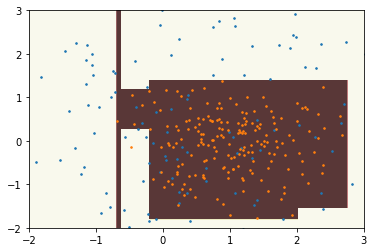

In [32]:
x1_train = x_train[y_train == 0]
x2_train = x_train[y_train == 1]

plt.figure()
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.contourf(xx, yy, pred, cmap="pink_r")
plt.scatter(*x1_train.T,s=2.5)
plt.scatter(*x2_train.T,s=2.5)

**Задание 4.1** Перед вами класс `BaseDecisionTree`. Используйте класс `MyDecisionTreeClassifier` в качестве примера, чтобы самостоятельно сделать простое дерево регрессии `MyDecisionTreeRegressor`.

Для задачи регрессии в качестве значения листа уместно взять среднее арифметическое значений всех точек содержащихся в узле, в качестве критерия - среднеквадратичное отклонение.

Используя синтетический пример с зависимостью (приведен ниже)
$$y = 2 x + 1 + \epsilon$$
удебитесь в работоспособности дерева регрессии, подберите наилучший параметр `max_depth`.

*Бонусные баллы* можно получить если реализовать функцию `impurity` более эффективно, упростив формулы для случая регрессии.

In [0]:
class MyDecisionTreeRegressor(BaseDecisionTree):
    def __init__(self, x, y, *args, random_state=None, **kwargs):
        y = np.asarray(y)
        self.random_state = np.random.RandomState(random_state)
        self.classes = np.unique(y)
        super().__init__(x, y, *args, **kwargs)
        
    def leaf_value(self, y):
        return np.mean(y)
    
    def criteria(self, y):
        # gini не подходит
        # нужно ср-квадр отклонение
        y_m = np.sum(y) / y.size
        return np.sum((y - y_m)**2) / y.size 

train score = 0.0000
test score = 0.0205


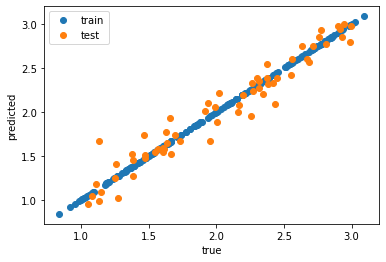

In [0]:
from sklearn.metrics import mean_squared_error

np.random.seed(42)

n = 250
x = np.random.uniform(0, 1, size=(n, 1))
y = 2 * x[:, 0] + 1
y = y + np.random.normal(0, 0.1, size=y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

dtr = MyDecisionTreeRegressor(x_train, y_train, max_depth=20, random_state=0)

plt.xlabel('true')
plt.ylabel('predicted')
plt.plot(y_train, dtr.predict(x_train), 'o', label='train')
plt.plot(y_test, dtr.predict(x_test), 'o', label='test')
plt.legend()

train_score = mean_squared_error(y_train, dtr.predict(x_train))
test_score = mean_squared_error(y_test, dtr.predict(x_test))

print("train score = {:.4f}".format(train_score))
print("test score = {:.4f}".format(test_score))

1
train score = 0.0907
test score = 0.0792
2
train score = 0.0275
test score = 0.0260
3
train score = 0.0131
test score = 0.0133
4
train score = 0.0086
test score = 0.0121
5
train score = 0.0072
test score = 0.0119
6
train score = 0.0051
test score = 0.0153
7
train score = 0.0031
test score = 0.0170
8
train score = 0.0008
test score = 0.0203
9
train score = 0.0002
test score = 0.0204
10
train score = 0.0001
test score = 0.0204
11
train score = 0.0000
test score = 0.0205
12
train score = 0.0000
test score = 0.0205
13
train score = 0.0000
test score = 0.0205
14
train score = 0.0000
test score = 0.0205
15
train score = 0.0000
test score = 0.0205
16
train score = 0.0000
test score = 0.0205
17
train score = 0.0000
test score = 0.0205
18
train score = 0.0000
test score = 0.0205
19
train score = 0.0000
test score = 0.0205


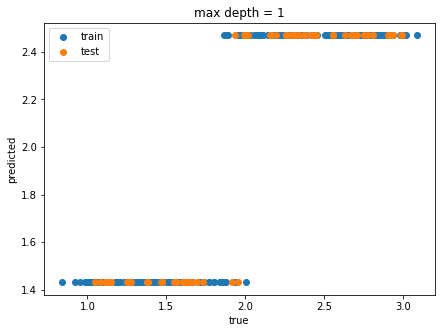

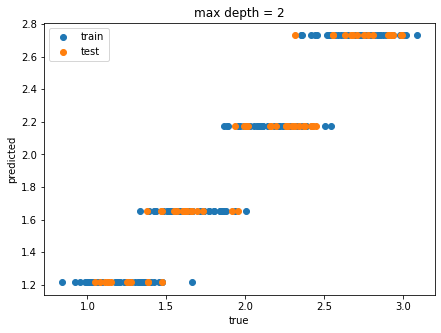

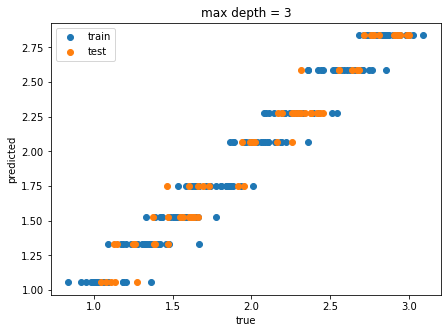

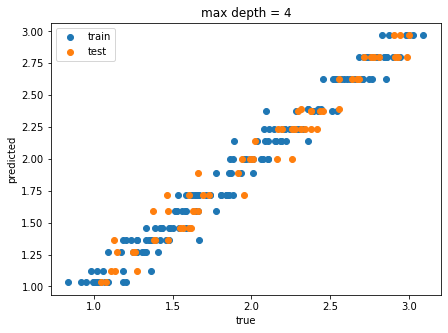

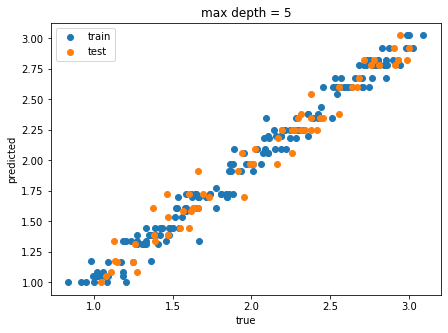

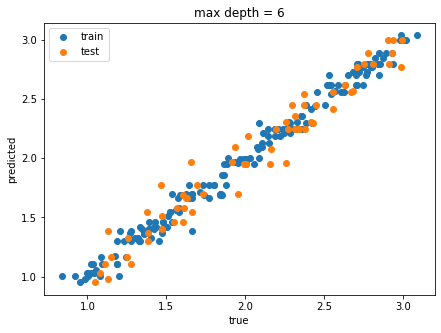

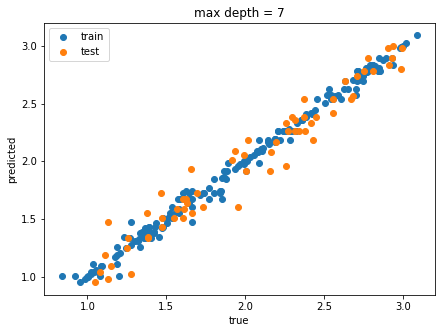

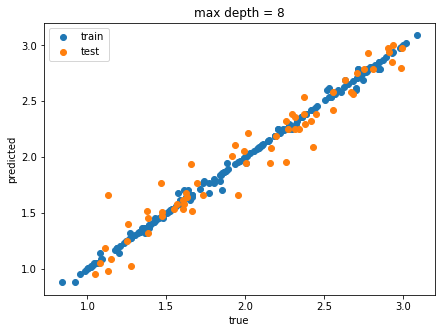

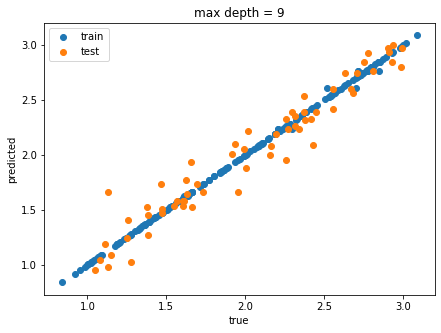

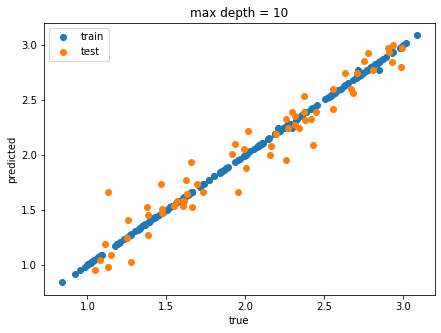

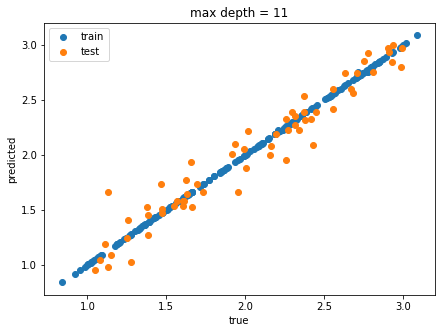

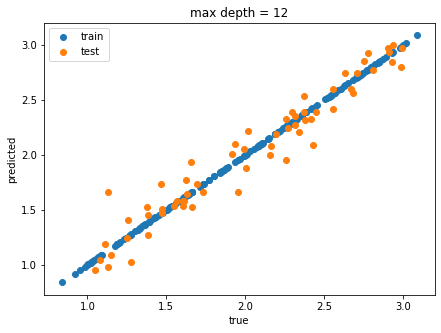

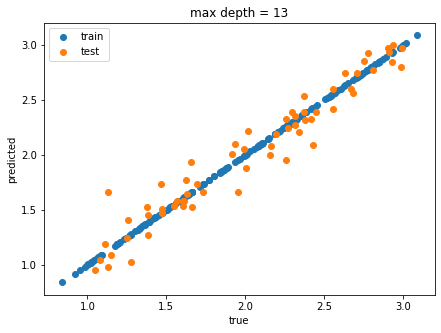

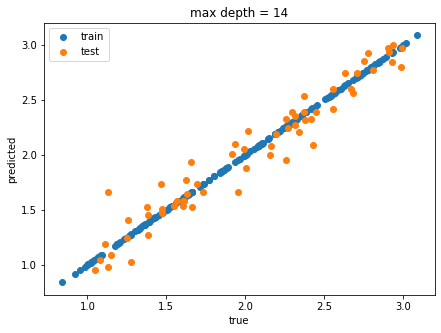

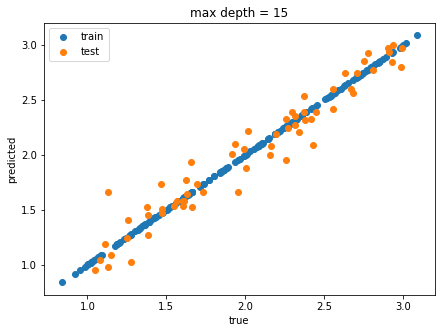

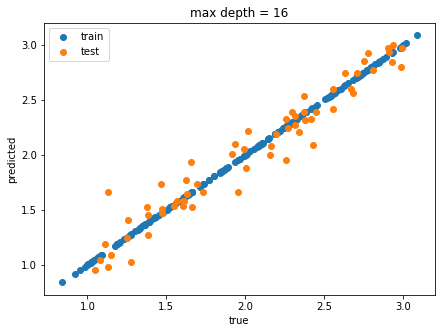

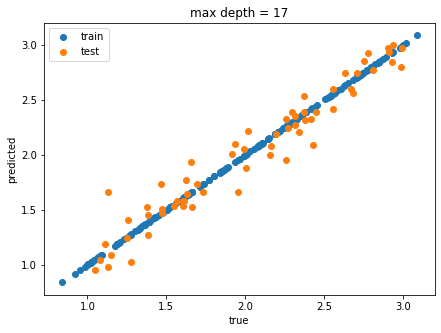

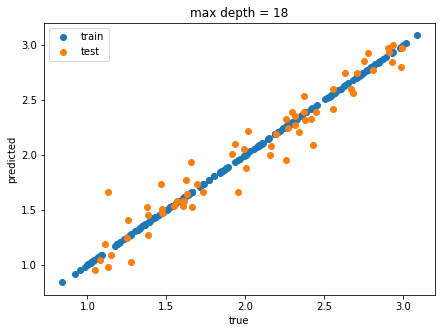

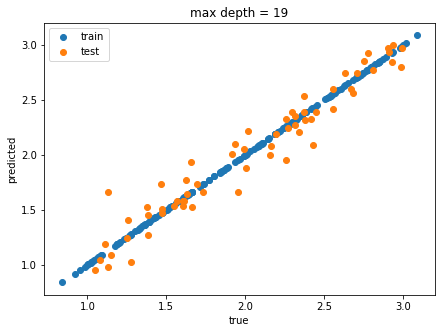

In [0]:
from sklearn.metrics import mean_squared_error

np.random.seed(42)

n = 250
x = np.random.uniform(0, 1, size=(n, 1))
y = 2 * x[:, 0] + 1
y = y + np.random.normal(0, 0.1, size=y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

depth_list = np.arange(1, 20, 1)

for d in depth_list:

    dtr = MyDecisionTreeRegressor(x_train, y_train, max_depth=d, random_state=0)

    plt.figure(figsize=(7,5))
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title("max depth = %s" %d)
    plt.plot(y_train, dtr.predict(x_train), 'o', label='train')
    plt.plot(y_test, dtr.predict(x_test), 'o', label='test')
    plt.legend()

    train_score = mean_squared_error(y_train, dtr.predict(x_train))
    test_score = mean_squared_error(y_test, dtr.predict(x_test))

    print(d)
    print("train score = {:.4f}".format(train_score))
    print("test score = {:.4f}".format(test_score))

 ## Оптимальная глубина 11

In [0]:
dtr.predict(x_train)

array([1.73828102, 1.93556654, 1.27278408, 2.92839135, 1.18468977,
       2.07612077, 1.36558956, 2.62497032, 1.33046665, 2.80421837,
       2.35557557, 1.18549509, 1.80592338, 1.06921896, 2.76657741,
       1.08872398, 2.36106149, 1.18741516, 1.05695536, 2.84976265,
       2.01202603, 2.38740058, 2.18863869, 2.98730657, 1.53841196,
       1.38860112, 1.02040778, 1.34923566, 2.70066402, 2.45552311,
       2.10754662, 0.99574038, 2.19250376, 1.64137835, 2.18841428,
       2.14447975, 2.21055087, 2.63550898, 1.86380964, 1.51203118,
       2.74736818, 2.51728388, 2.0583136 , 2.56022266, 1.2075677 ,
       1.88017259, 1.99065231, 1.36782064, 2.73198321, 1.2663455 ,
       1.53639418, 2.28461906, 1.66440087, 2.41933639, 1.02331099,
       1.83781656, 1.09095756, 2.72356155, 2.85782492, 3.09010151,
       1.2461687 , 1.65138995, 1.38890403, 1.64584365, 1.03565974,
       1.56203435, 1.58319623, 2.29815018, 3.02273043, 2.82552267,
       1.00397255, 2.80834845, 2.1043658 , 1.43341623, 1.33344

Случайный лес
------------------------

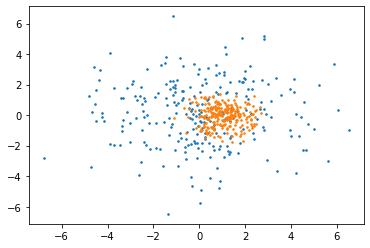

In [0]:
np.random.seed(43)

n = 250

mu1 = np.array([0.0,0])
mu2 = np.array([1.0,0])
sigma1 = 5.0 * np.diag(np.array([1.0, 1.0]))
sigma2 = 0.5 * np.diag(np.array([1.0, 1.0]))

x1 = np.random.multivariate_normal(mu1, sigma1, n)
x2 = np.random.multivariate_normal(mu2, sigma2, n)
x = np.vstack([x1, x2])
y = np.concatenate([np.full(x1.shape[0], 0), np.full(x2.shape[0], 1)])

plt.figure()
plt.scatter(*x1.T,s=2.5)
plt.scatter(*x2.T,s=2.5)

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

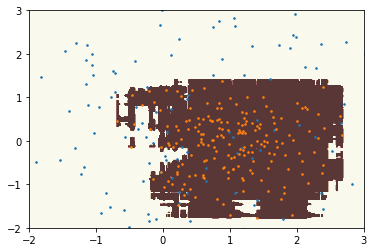

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

c = RandomForestClassifier(random_state=0, max_depth=15)

c.fit(x_train, y_train)
pred = c.predict(xx_test).reshape(xx.shape)

x1_train = x_train[y_train == 0]
x2_train = x_train[y_train == 1]

plt.figure()
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.contourf(xx, yy, pred, cmap="pink_r")
plt.scatter(*x1_train.T,s=2.5)
plt.scatter(*x2_train.T,s=2.5)

**Задание 4.2** Используйте готовый класс `RandomForestClassifier` чтобы проверить как работает классификация с помощью метода случайного леса. С помощью метода кросс-валидации получите и постройте на графике зависимость точности (accuracy) (для учебного и тестового множеств) от максимальной глубины деревьев случайного леса. Используйте данные из примера про дерево классификации.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

max_depths = np.arange(1, 2 * np.log2(n))

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for max_depth in max_depths:
    c = RandomForestClassifier(max_depth=max_depth)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

In [0]:
scores = flat_dict(scores)

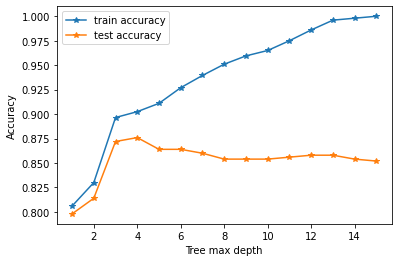

In [0]:
plt.plot(max_depths, scores['train_accuracy'].mean(axis=1), '-*', label="train accuracy")
plt.plot(max_depths, scores['test_accuracy'].mean(axis=1), '-*', label="test accuracy")
plt.xlabel("Tree max depth")
plt.ylabel("Accuracy")
_ = plt.legend()

In [0]:
import sklearn.metrics

def evaluate(c, x, y):
    y_pred = c.predict(x)
    if getattr(c, "decision_function", None):
        scores = c.decision_function(x)
    else:
        scores = c.predict_proba(x)[:,1]

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, y_pred, labels=['h', 'g']).ravel()
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)
    f1 = 2 * precision * recall / (precision + recall)
    
    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("F1                        = {:.4f}".format(f1))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))
    print("Specificity (TNR, 1-FPR)  = {:.4f}".format(specificity))
    
    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y.reshape(-1) == 'h'], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y.reshape(-1) == 'g'], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()
    
    tpr, fpr, _ = sklearn.metrics.roc_curve(y, scores, pos_label='g')
    auc = sklearn.metrics.roc_auc_score(y, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

names = ["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
data = pd.read_csv('/content/drive/My Drive/2020-hw4-propellermint/magic04.csv', names=names)

x = np.asarray(data.iloc[:, :-1])
y = np.asarray(data.iloc[:, [-1]])

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Accuracy                  = 0.8774
Ballanced accuracy        = 0.8499
F1                        = 0.9090
Precision (PPV)           = 0.8787
Recall (sensitivity, TPR) = 0.9415
Specificity (TNR, 1-FPR)  = 0.7583
AUC                       = 0.9308


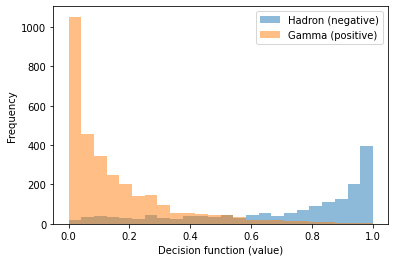

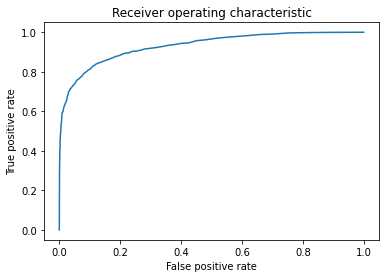

In [35]:
from sklearn.ensemble import RandomForestClassifier

c = RandomForestClassifier(random_state=0)

c.fit(x_train, y_train.reshape(-1))

train_acc = c.score(x_train, y_train) # accuracy
test_acc = c.score(x_test, y_test)

evaluate(c, x_test, y_test)

**Задания 4.3 нет!**

**Задание 4.4**

Используя данные с черенковского телескопа из файла `magic04.csv` и метод кросс-валидации подберите максимальную глубину случайного леса таким образом, чтобы получить наилучший AUC при бинарной классификации методом случайного леса (`RandomForestClassifier`).
Постройте график зависимости AUC от глубины дерева.

In [0]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

max_depths = np.arange(1, 2 * np.log2(x.shape[0]))#, 2)

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for max_depth in tqdm(max_depths):
    c = RandomForestClassifier(max_depth=max_depth)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

100%|██████████| 28/28 [10:07<00:00, 21.71s/it]


In [0]:
scores = flat_dict(scores)

np.set_printoptions(precision=4)
print("fit time = {}".format(scores['fit_time'].mean(axis=1)))
for s in scoring.keys():
    print("{} = {}".format(s, scores["test_{}".format(s)].mean(axis=1)))

fit time = [0.6316 0.993  1.3381 1.683  2.0136 2.3149 2.6335 2.9031 3.1571 3.4564
 3.6766 3.8754 4.0779 4.2905 4.4317 4.5527 4.6686 4.7911 4.872  4.9364
 4.9899 5.0707 5.1022 5.1119 5.1309 5.1111 5.1363 5.171 ]
auc = [0.8216 0.8667 0.8766 0.8845 0.8954 0.9049 0.9133 0.9188 0.9228 0.9264
 0.9279 0.9304 0.9319 0.9326 0.9336 0.9343 0.9342 0.9345 0.9348 0.9345
 0.9355 0.9356 0.9354 0.9349 0.9351 0.9355 0.9353 0.9352]
accuracy = [0.728  0.7748 0.8014 0.8264 0.8393 0.8476 0.8544 0.8599 0.8654 0.87
 0.871  0.8726 0.8755 0.8777 0.8778 0.879  0.878  0.8778 0.8792 0.8798
 0.8812 0.8811 0.8812 0.8792 0.8792 0.8801 0.8803 0.8792]


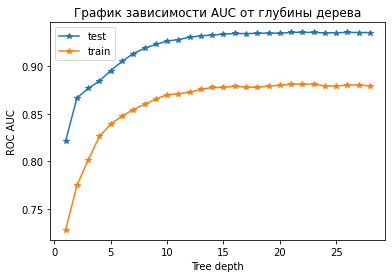

In [0]:
plt.plot(max_depths, scores['test_auc'].mean(axis=1),'-*', label='test')
plt.plot(max_depths, scores['test_accuracy'].mean(axis=1),'-*', label='train')
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC")
plt.title("График зависимости AUC от глубины дерева")
plt.legend()

#plt.figure()
#plt.plot(max_depths, scores['fit_time'].mean(axis=1),'-*')
#plt.xlabel("Depth")
#plt.ylabel("Fit time")

### Оптимальная глубина - 16

Адаптивный бустинг
----------------

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy                  = 0.8772
Ballanced accuracy        = 0.8455
F1                        = 0.9097
Precision (PPV)           = 0.8719
Recall (sensitivity, TPR) = 0.9508
Specificity (TNR, 1-FPR)  = 0.7402
AUC                       = 0.9244


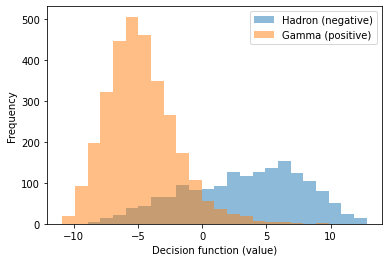

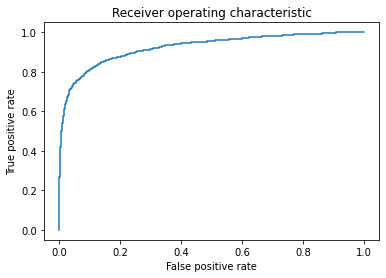

In [0]:
from sklearn.ensemble import AdaBoostClassifier

c = AdaBoostClassifier(random_state=0, n_estimators=200,
                       base_estimator=DecisionTreeClassifier(max_depth=10))

c.fit(x_train, y_train)

evaluate(c, x_test, y_test)

**Задание 4.5**

Используя данные с черенковского телескопа из файла `magic04.csv` и метод кросс-валидации подберите максимальную глубину дерева классификации, чтобы получить наилучший AUC при бинарной классификации методом адаптивного бустинга (`AdaBoostClassifier`).
Постройте график зависимости AUC от глубины дерева.

In [0]:
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate

max_depths = np.arange(1, 2 * np.log2(x.shape[0]), 2)

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for max_depth in tqdm(max_depths):
    c = AdaBoostClassifier(random_state=0, n_estimators=200,
                           base_estimator=DecisionTreeClassifier(max_depth=max_depth))
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

100%|██████████| 14/14 [42:16<00:00, 181.17s/it]


In [0]:
scores = flat_dict(scores)

np.set_printoptions(precision=4)
print("fit time = {}".format(scores['fit_time'].mean(axis=1)))
for s in scoring.keys():
    print("{} = {}".format(s, scores["test_{}".format(s)].mean(axis=1)))

fit time = [ 7.5448 14.8958 21.961  28.3308 33.3331 36.6892 38.8894 40.4332 41.7964
 42.3923 42.5125 43.2857 44.3024 44.4035]
auc = [0.902  0.9    0.8816 0.9107 0.9258 0.9307 0.9315 0.9336 0.9347 0.9348
 0.9359 0.9354 0.9352 0.9354]
accuracy = [0.8476 0.859  0.8442 0.8642 0.8764 0.8789 0.8797 0.88   0.8808 0.8809
 0.8811 0.8803 0.8798 0.8808]


Text(0, 0.5, 'ROC AUC')

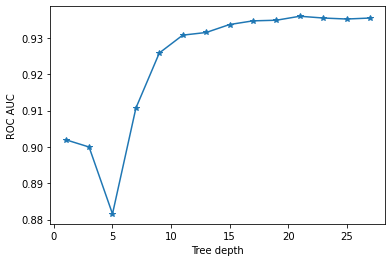

In [0]:
plt.plot(max_depths, scores['test_auc'].mean(axis=1),'-*')
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC")

### Оптимальная глубина - 20

Градиентный бустинг
------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy                  = 0.8814
Ballanced accuracy        = 0.8550
F1                        = 0.9118
Precision (PPV)           = 0.8828
Recall (sensitivity, TPR) = 0.9428
Specificity (TNR, 1-FPR)  = 0.7673
AUC                       = 0.9322


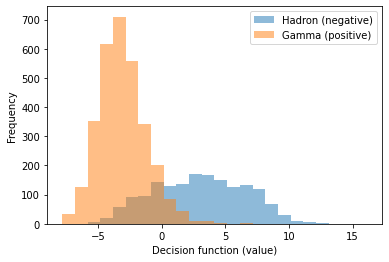

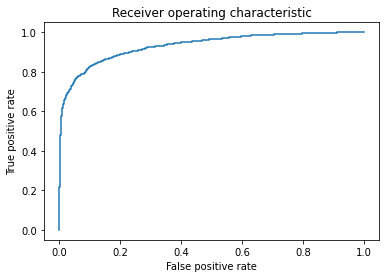

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

c = GradientBoostingClassifier(random_state=0, n_estimators=2000, max_depth=3)

c.fit(x_train, y_train)

evaluate(c, x_test, y_test)

**Задание 4.6**

Используя данные с черенковского телескопа из файла `magic04.csv` и метод кросс-валидации подберите максимальную глубину дерева классификации, чтобы получить наилучший AUC при бинарной классификации методом градиентного бустинга (`GradientBoostingClassifier`).
Постройте график зависимости AUC от глубины дерева.

In [0]:
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

max_depths = np.arange(1, 2 * np.log2(x.shape[0]), 2)

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for max_depth in tqdm(max_depths):
    c = GradientBoostingClassifier(random_state=0, n_estimators=2000, max_depth=max_depth)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

100%|██████████| 14/14 [1:45:08<00:00, 450.64s/it]


In [0]:
scores = flat_dict(scores)

np.set_printoptions(precision=4)
print("fit time = {}".format(scores['fit_time'].mean(axis=1)))
for s in scoring.keys():
    print("{} = {}".format(s, scores["test_{}".format(s)].mean(axis=1)))

fit time = [ 39.538  108.7428 177.6151 245.9717 205.4637 127.2081  84.9761  58.564
  44.4307  35.5315  31.7573  29.5009  29.2963  28.6404]
auc = [0.9065 0.9341 0.9348 0.9355 0.9366 0.937  0.9369 0.9344 0.9315 0.9262
 0.9197 0.9128 0.91   0.91  ]
accuracy = [0.857  0.8822 0.8844 0.8842 0.8849 0.8852 0.8831 0.8793 0.8768 0.8686
 0.8601 0.8516 0.8421 0.8346]


Text(0, 0.5, 'ROC AUC')

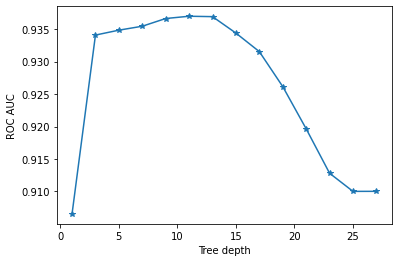

In [0]:
plt.plot(max_depths, scores['test_auc'].mean(axis=1),'-*')
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC")

### Оптимальная глубина - 13

**Задание 4.7**

За это задание можно получить *бонусные баллы*, за три наилучших решения среди всей группы.

Используя один из четырех рассмотренных выше методов классификации с помощью деревьев, постройте бинарный классификатор для данных с черенковского телескопа из файла `magic04.csv` с наилучшим AUC для тестового набора данных. Можно подбирать любые гиперпараметры, которые окажется необходимо. Используйте функцию `evaluate`, чтобы нарисовать гистограмы классов и напечатать значения мер эффективности|.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy                  = 0.8864
Ballanced accuracy        = 0.8600
F1                        = 0.9157
Precision (PPV)           = 0.8855
Recall (sensitivity, TPR) = 0.9479
Specificity (TNR, 1-FPR)  = 0.7721
AUC                       = 0.9344


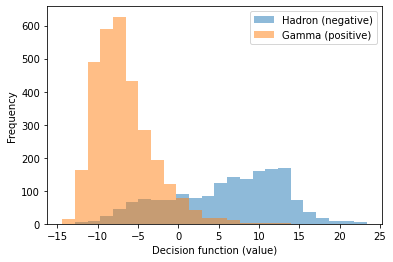

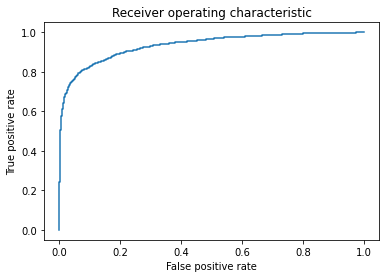

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

c = GradientBoostingClassifier(random_state=0, n_estimators=2000, max_depth=7)

c.fit(x_train, y_train)

train_ac = c.score(x_train, y_train)
test_ac = c.score(x_test, y_test)

evaluate(c, x_test, y_test)

Изолирующий лес
-----------------------------

In [0]:
import numpy as np
import pandas as pd

wl = np.asarray([7.8636, 8.0485, 8.2286, 8.4043, 8.5758, 8.7436, 8.9078, 9.0686,\
                 9.2262, 9.3809, 9.5328, 9.6820, 9.8286, 9.9728, 10.1148, 10.2545,\
                 10.3922, 10.5279, 10.6616, 10.7935, 10.9237, 11.0521, 11.1790,\
                 11.3042, 11.4280, 11.5503, 11.6711, 11.7907, 11.9089, 12.0258,\
                 12.1415, 12.2560, 12.3693, 12.4816, 12.5927, 12.7028, 12.8118,\
                 12.9199, 13.0269, 13.1330, 13.2382, 13.3425, 13.4459, 13.5485,\
                 10.9929, 11.3704, 11.7357, 12.0899, 12.4339, 12.7687, 13.0948,\
                 13.4131, 13.7239, 14.0278, 14.3252, 14.6166, 14.9022, 15.1825,\
                 15.4576, 15.7280, 15.9937, 16.2551, 16.5123, 16.7656, 17.0151,\
                 17.2610, 17.5034, 17.7425, 17.9784, 18.2113, 18.4412, 18.6682,\
                 18.8925, 19.1142, 19.3334, 19.5500, 19.7643, 19.9763, 20.1861,\
                 20.3937, 20.5992, 20.8026, 21.0041, 21.2037, 21.4014, 21.5973,\
                 21.7914, 21.9838, 22.1745, 22.3636, 22.5511, 22.7371, 22.9216])
data = pd.read_csv('/content/drive/My Drive/2020-hw4-propellermint/lrs.csv', header=None)

x = np.asarray(data.iloc[:, 11:54])
wl = wl[:x.shape[1]]

Text(0.5, 0, 'Wavelength (um)')

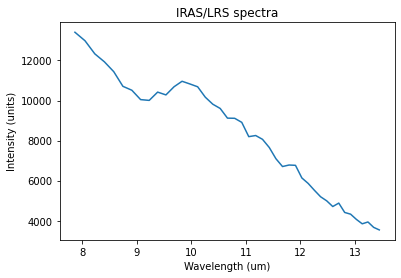

In [0]:
plt.plot(wl, x[6,:], "-")
plt.title("IRAS/LRS spectra")
plt.ylabel("Intensity (units)")
plt.xlabel("Wavelength (um)")

In [0]:
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(x)

c = IsolationForest(n_estimators=2000, contamination=0.1)
c.fit(z)

pred = c.predict(z)

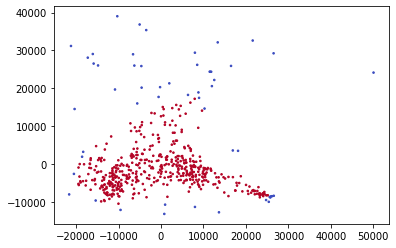

In [0]:
_ = plt.scatter(*z.T, s=2.5, c=pred, cmap="coolwarm")

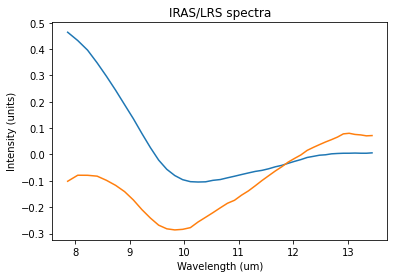

In [0]:
plt.figure()
plt.plot(wl, pca.components_[0,:], "-")
plt.plot(wl, pca.components_[1,:], "-")
plt.title("IRAS/LRS spectra")
plt.ylabel("Intensity (units)")
_ = plt.xlabel("Wavelength (um)")

**Задание 4.8**

Используйте данные спектров космических объектов с ИК спутника из файла `lsr.csv` и метод изолирующего леса `IsolationForest`, чтобы найти 10 наболее отличных от остальных спектров. Распечатайте соответсвтвующие таким спектрам строки из исходного объекта `data`. Нарисуйте на графике самый необычный спектр.

In [0]:
data['scores'] = c.decision_function(z)
data.sort_values('scores')[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,scores
306,306,18316-0602,79,3,18.527,-6.036,0.0,874,943,481,514,34736.3870,36548.8050,34748.8200,29966.5980,23261.8220,14702.7260,9419.1420,5299.7200,2163.8264,565.3829,701.0641,1647.6538,1707.2407,-151.7691,457.8867,-297.1386,-209.1590,1151.3110,-679.2621,-221.8108,71.1237,67.0773,-89.4440,697.3641,-470.5779,1644.9502,2098.7420,1870.2054,3142.9307,...,5625.5005,5232.9507,4699.9766,4219.2460,2594.5916,2683.9573,3704.6145,3047.4834,3550.4355,3507.5327,3460.6577,3245.2373,2692.6821,3617.3047,3205.3113,3287.0706,3107.9539,3450.6858,2830.0960,3349.5022,3463.5256,3621.7300,3804.0452,3946.2463,4766.8320,4178.5396,4762.3486,4406.9116,4609.4390,5289.6494,5235.3230,5044.5430,5146.8020,5289.2197,5624.3257,6047.7580,6182.2017,6035.6846,5311.1720,-0.207087
234,234,17317-3331,79,3,17.529,-33.526,0.0,609,608,675,585,21093.0020,21667.6040,20890.0430,16939.7360,12384.8760,9249.0970,6390.2104,4426.6133,2416.8667,1500.8502,294.0943,393.3539,483.3831,-19.6029,123.4963,585.0229,298.9354,45.1516,338.2328,529.7856,592.1210,871.3561,919.8458,1067.5554,1835.9683,2069.0527,2565.1858,3275.9119,3908.1838,...,6809.4040,6509.8290,6316.2970,6168.8150,5942.7905,5665.9155,5215.9020,4883.4890,4592.5380,4589.9478,4220.4067,4116.1587,3868.7886,3725.1943,3782.2925,3594.7473,3658.6636,3595.6194,3576.3680,3550.1490,3683.0999,3721.4033,3745.8186,3841.7256,3995.2805,3888.0564,4078.4563,3941.1626,3956.1255,4104.8887,3916.7317,3783.9224,4234.8667,4706.5480,4739.7856,4655.3140,4607.7350,4363.9956,3896.4087,-0.175151
280,280,18135-1456,79,3,18.226,-14.939,0.0,1845,2007,1536,1660,4157.8867,4614.5977,3422.2920,4053.0120,4554.4146,4259.6940,2707.8716,2983.9778,1215.3859,1267.3188,1267.5504,142.5410,76.3389,1187.2653,92.0091,1537.0553,1381.0911,-158.9643,788.2794,1957.4240,1783.1464,2162.3147,1358.2906,2176.3152,2347.2974,2789.4688,2566.1050,3328.8022,3598.5127,...,8637.5110,8912.3780,8807.6980,7942.6170,7337.6655,7490.7876,6490.3160,6018.6600,5484.1973,5462.5210,5463.0790,5476.0093,5279.4540,4716.8784,5176.1150,5247.1436,5116.0737,4914.7860,4500.3057,5025.0503,5228.1353,5549.5750,5718.2130,5826.4844,5906.4365,6218.1323,6430.0195,6416.3800,6203.0957,6252.3647,6832.8790,6717.0350,6824.3030,6563.0650,5861.8330,6150.3477,6236.7460,5625.5510,4754.3080,-0.173464
295,295,18257-1000,39,0,18.429,-10.004,0.0,670,713,377,445,25896.0470,25140.3260,22664.3320,17620.3950,13824.3890,9761.6340,6735.5800,4932.4375,3710.1987,2290.6785,865.6380,971.9910,1350.7448,528.9061,652.0377,844.6796,1545.9515,1741.4303,1180.9852,1004.1009,1146.8520,1159.0023,1096.1373,919.3442,1020.4968,1143.9020,2312.3179,2691.4524,3201.2270,...,6620.0160,6393.1196,6533.1733,6425.9644,5854.7056,5258.5130,4745.7695,4430.4233,4123.4810,4058.3955,3818.2788,3906.1692,3479.9573,3556.8398,3325.2780,3046.5190,2906.7668,3028.3088,3110.9858,2907.4430,2701.1614,3128.5825,2813.9890,3230.3682,3471.6910,3134.9680,3615.3720,3187.0002,2983.7780,3444.8213,3714.1267,3344.2380,3591.3662,3649.5344,3688.2740,3451.8958,3285.0230,3198.7722,2484.4382,-0.173352
381,381,19500-1709,5,2,19.834,-17.161,0.0,3087,3070,1754,1940,-460.8965,798.8571,1666.7008,599.7642,1561.7616,1680.0234,2169.2527,2125.7944,1510.6500,2113.0552,2080.9946,1902.4419,2298.4180,2459.4395,2981.9182,2695.8600,2670.4310,3573.3838,4099.6520,4044.7240,4230.4500,4683.4650,4986.1840,5071.0728,5067.4950,5551.8880,5598.7197,6047.9120,5939.6904,...,5715.7485,5885.5537,6421.6626,6029.4690,6474.4204,6091.8896,6096.5710,5638.0770,6341.0796,6292.6820,6051.2437,6465.2470,6847.9120,5892.2676,5625.3500,6124.2070,6180.7915,6004.3720,6273.1616,6065.4326,6171.6410,6845.7607,6328.0460,5905.4850,6425.6113,6545.3076,6606.0600,6234.0400,6441.3403,6514.5464,6325.2446,6062.7256,6307.2310,6199.8120,6497.6353,5788.1455,5915.7485,5758.0107,5419.5630,-0.173277
89,89,1